In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize
from dask_ml.wrappers import Incremental

from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [2]:
def read_trials(filename):
    pairs = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    print("num of trials: ",len(pairs))

    # Encode "nontarget" as 0, "target as 1"
    pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
    print(pairs.head())
    return pairs

def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER: ", fpr[minPt])
    
    if name:
        plt.savefig(name)
    
    return

def run_test(score_func, sample_size = 0.10, ESPK = 0, TSPK = 0, n_features = 1, dask_array = False):

    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = ESPK.loc[x['enroll']] # Pandas series
        test_data = TSPK.loc[x['test_id']]
        res = score_func(enroll_data, test_data)
        return res

    dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= sample_size, random_state=1)
    #dask_pairs = dd.from_pandas(pairs, npartitions=16)
    meta = ('x','f8')

    scores = 0
    
    pbar = ProgressBar()
    pbar.register()
    scores = dask_pairs.map_partitions(lambda df: df.apply(score_vectors ,axis=1), meta=meta)
    
    #New impl returns data in stacked format and takes 1/3 time
    if n_features>1: # This conditional halves the time if n_features==1
        scores = dask.array.from_delayed(delayed(np.vstack)(scores.values), shape=(len(dask_pairs), n_features), dtype='float64')
        scores = scores.rechunk((1000,500))
    res =  dask.array.from_array(np.array(dask_pairs['result']), (1000,))
    #res.rechunk((1000,500))
    if dask_array:
        pbar.unregister()
        return scores, res
    
    #scores = scores if delayed_res else scores.compute() #Turns out it is faster to do dd.compute(*(scores.compute())) if the inner func produces delayed objs
    scores = scores.compute(get=get)
    res = res.compute()
    pbar.unregister()
    
    return scores, res

def load_sample(enroll, test, eid = 4780420411, tid = 'fc_4779547143_0'):
    return enroll.loc[eid], test.loc[tid]

def sendScores(scores, res, name):
    pd.DataFrame(data=np.vstack((scores, res))).to_hdf("scores.h5", name)

In [5]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

enroll_spk.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
4780420411,0.014026,0.054789,0.025725,0.016863,0.063301,0.114704,0.070258,0.000567,0.045729,0.044964,...,0.077940,0.032820,0.022656,0.028034,0.035296,0.046987,0.036155,0.016219,0.011507,0.070774
4779876202,0.030303,0.022931,0.033079,0.058957,0.079296,0.049778,0.068490,0.003525,0.072742,0.030553,...,0.061358,0.044687,0.020264,0.007364,0.051940,0.062175,0.052892,0.026529,0.014570,0.025142
4778192381,0.055344,0.035090,0.026809,0.068782,0.045188,0.081985,0.033221,0.012631,0.026813,0.046449,...,0.075565,0.056208,0.029324,0.006928,0.055884,0.062326,0.022718,0.040709,0.015717,0.102008
4780265567,0.012624,0.058721,0.033892,0.054483,0.041132,0.115025,0.074992,0.000893,0.087311,0.076028,...,0.068856,0.051828,0.054921,0.011270,0.066159,0.043747,0.031619,0.033663,0.032096,0.073277
4777987958,0.054659,0.054360,0.014665,0.050420,0.064626,0.115716,0.107942,0.008013,0.069778,0.092527,...,0.102160,0.041830,0.015103,0.031850,0.061312,0.079773,0.071351,0.070432,0.031396,0.099793


In [4]:
enroll_ark = dd.read_hdf("enroll.ark_raw.h5", '/*')
test_ark = dd.read_hdf("test.ark_raw.h5", '/*')

In [6]:
pairs = read_trials("trials")

num of trials:  11725308
       enroll          test_id  result
0  4780420411  fc_4779547143_0       0
1  4780420411  fc_4779547143_1       0
2  4780420411  fc_4779547143_2       0
3  4780420411  fc_4779547143_3       0
4  4780420411  fc_4779547143_4       0


In [6]:
# some comparison functions

def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

def cos_with_variance(dist1, vect2):
    m = dist1.mean(axis=0)
    cos = 1 - cosine(m, vect2)
    v = dist1.var(axis=0)
    return np.concatenate([np.array([cos]), v])

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sscaler = StandardScaler()

In [8]:
spkr, test = load_sample(enroll=enroll_spk_raw, test=test_spk)

In [8]:
def read_spk2utt_utts(filename):  
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    df.index = df['id']
    df = df.drop('id', 1)
    return df 

In [9]:
enroll_utts = read_spk2utt_utts("enroll.spk2utt")
enroll_utts.head()

,utt1,utt2,utt3,utt4,utt5
id,,,,,
4780420411,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...
4779876202,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...
4778192381,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...
4780265567,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...
4777987958,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...


# Tests
1. KL Divergence
2. Mahalanobis distance (after dimension reduction)

These next 3 were actually not pursued for fear of redudancy 

3. Total variational distance
4. Hellinger Distance
5. Jensen-Shannon Divergence

# 1. Kullback-Leibler Divergence - note: this is revisted in `Similarity Test KL.ipynb` with more successful results

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

Mean and sum end up both getting EER of 50%

In [12]:
from scipy.stats import entropy

In [13]:
spkr, test = load_sample(enroll_spk_raw, test_spk_raw)

In [32]:
def kl_div(spkr, test):
    """Calc KL divergence of two speakers given utterance vectors of each"""
    # Use a sliding window of n_utterances of the test speaker to go over spkr's utterances 
    spkr = spkr.values
    test = test.values
    res = np.array([])
    for i in range(len(spkr)-len(test)+1):
        a = entropy(spkr[i:i+len(test)], test)
        #a[a==np.inf] = 1000
        a[np.isnan(a)] = 0
        res =np.append(res, a)
    return np.min(res)

In [15]:
import warnings; warnings.simplefilter('ignore')

In [46]:
kl_scores, res = run_test(kl_div, 0.10, enroll_spk_raw, test_spk_raw)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed | 27min 37.1s
[########################################] | 100% Completed |  0.3s


(array([1.157081e+06, 1.266700e+04, 2.155000e+03, 4.430000e+02,
        1.240000e+02, 3.300000e+01, 1.900000e+01, 1.000000e+00,
        2.000000e+00, 3.000000e+00]),
 array([0.00000000e+00, 6.06782008e-05, 1.21356402e-04, 1.82034602e-04,
        2.42712803e-04, 3.03391004e-04, 3.64069205e-04, 4.24747406e-04,
        4.85425606e-04, 5.46103807e-04, 6.06782008e-04]),
 <a list of 10 Patch objects>)

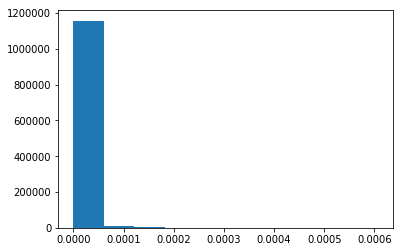

In [47]:
plt.hist(kl_scores, bins=10)

(array([177.,   3.,   4.,   1.,   1.,   1.,   1.,   2.,   1.,   1.]),
 array([0.00000000e+00, 8.03788001e-06, 1.60757600e-05, 2.41136400e-05,
        3.21515200e-05, 4.01894001e-05, 4.82272801e-05, 5.62651601e-05,
        6.43030401e-05, 7.23409201e-05, 8.03788001e-05]),
 <a list of 10 Patch objects>)

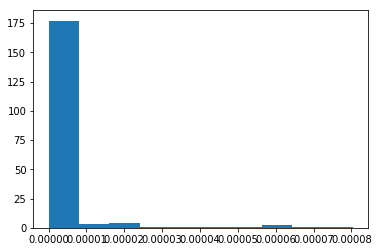

In [38]:
plt.hist(kl_scores[res==1])

Threshold:  1.0556269843908271e-11
EER:  0.09609088385402208


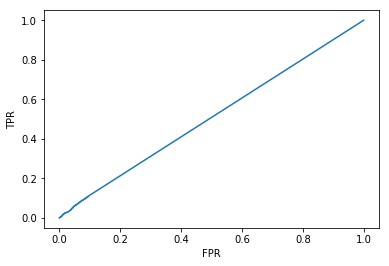

In [48]:
calcEER(kl_scores, res)

In [50]:
def kl_div_med(spkr, test):
    """Calc KL divergence of two speakers given utterance vectors of each"""
    # Use a sliding window of n_utterances of the test speaker to go over spkr's utterances 
    spkr = spkr.values
    test = test.values
    res = np.array([])
    for i in range(len(spkr)-len(test)+1):
        a = entropy(spkr[i:i+len(test)], test)
        #a[a==np.inf] = 1000
        a[np.isnan(a)] = 0
        res =np.append(res, a)
    return np.median(res)

In [51]:
kl_scores_med, res = run_test(kl_div_med, 0.01, enroll_spk_raw, test_spk_raw)

[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  2min 55.5s
[########################################] | 100% Completed |  2min 55.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


Threshold:  0.039228586223814504
EER:  0.5244583788955713


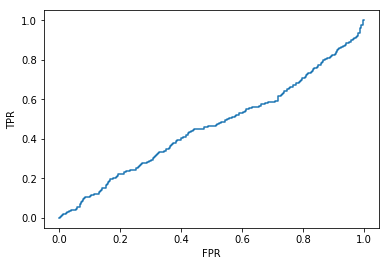

In [52]:
calcEER(kl_scores_med, res)

## Frame level KL

In [ ]:
def kl_div_med(spkr, test):
    """Calc KL divergence of two speakers given utterance vectors of each"""
    # Use a sliding window of n_utterances of the test speaker to go over spkr's utterances 
    spkr = spkr.values
    test = test.values
    res = np.array([])
    for i in range(len(spkr)-len(test)+1):
        a = entropy(spkr[i:i+len(test)], test)
        #a[a==np.inf] = 1000
        a[np.isnan(a)] = 0
        res =np.append(res, a)
    return np.median(res)

def kl_div_frame(spkr_utts, test_utts):
    

# 2. Mahalanobis Distance

It was previously seen that MD couldn't really be pursued with utterance-level speaker vectors because covariances were not always positive-definite and were sometimes singular. 

Some dimension-reduction can be used beforehand.

### PCA 

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

In [186]:
def cos_similarity_stdscaled(spkr, test):
    sscaler = StandardScaler()
    return cos_similarity(sscaler.fit_transform(spkr.values).mean(axis=0), sscaler.transform(test.values).mean(axis=0))

In [187]:
scores, res = run_test(cos_similarity_stdscaled, 0.01, enroll_spk_raw, test_spk_raw)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed | 39.4s
[########################################] | 100% Completed | 39.4s
[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 39.5s
[########################################] | 100

Threshold:  0.5370161987283264
EER:  0.45441498086386


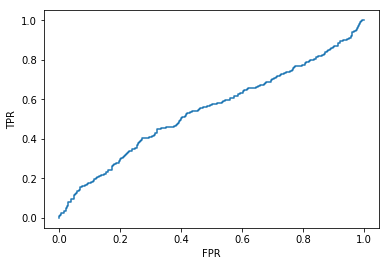

In [188]:
calcEER(scaler.fit_transform(scores), res )

In [217]:
def cos_similarity_pca(spkr, test):
    """Cos similarity after pca"""
    spkr = spkr.values
    test = test.values
    sscaler = StandardScaler()
    a = pca.fit_transform(sscaler.fit_transform(spkr)).mean(axis=0)
    b = pca.transform(sscaler.transform(test)).mean(axis=0)
    return cos_similarity(a,b)

- ~~See if changing the pca fit for each enroll/test or using same changes anything~~
- ~~See if changing scaling fit changes anything~~ On its own - creating a new SScaler for each function improves EER by a bit
- ~~See if changing pca components does stuff~~ - 100 components vs 2 is better - but in general this is probably a bad idea
- ~~See if operating on ARK data is different~~ - regular zscore is bad 

In [218]:
scores, res = run_test(cos_similarity_pca, 0.01, enroll_spk_raw, test_spk_raw)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  2min 49.9s
[########################################] | 100% Completed |  2min 49.9s
[###################################

Threshold:  0.03424388547024071
EER:  0.4775492072170585


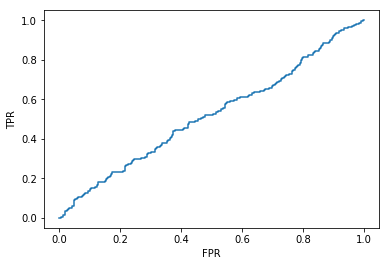

In [219]:
calcEER(scores, res )

In [55]:
pca = PCA(n_components = 4)

In [52]:
def md_pca(spkr, test):
    a = spkr.values
    m = a.mean(axis=0)
    a = pca.fit_transform(a)
    m = pca.transform(m.reshape(1,-1))
   
    test = pca.transform(np.array(test).reshape(1,-1))
    cov = np.cov(a, rowvar=False)
    inv = np.linalg.inv(cov)

    return mahalanobis(test,m , inv)

In [56]:
md_pca(spkr, test)

1.0636098658359148

In [57]:
scores, res = run_test(md_pca, 0.01, enroll_spk_raw, test_spk)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  2min 23.6s
[########################################] | 100% Completed |  2min 23.7s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


Threshold:  0.8891647208326268
EER:  0.5600994395844724


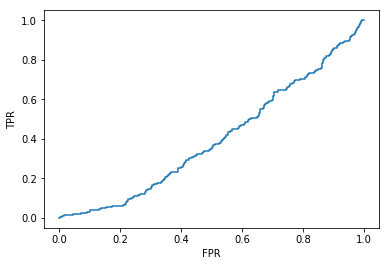

In [60]:
calcEER(scores, res)

# 3. Z-score stuff

Taking the median of vertical z-score produces EER of about 0.20. This was better than taking the mean, which yielded 0.22 EER.

In [115]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

In [7]:
def zscore_col_plusCos(spkr, test):
    z = (zscore_col(spkr, test))
    c = cos_similarity(spkr.mean(axis=0), test)
    return c-0.01*z

# takes spkr from raw, test from spk, and returns a single value
def zscore_col(spkr, test):
    std = np.std(spkr, axis=0)
    scores = np.absolute(np.divide((test-spkr.mean(axis=0)), np.where(std!=0, std, 0.0000001)) )
    res = np.median(scores)
    return np.where(res<50, res, 100) 

return (np.exp(c) - (z)*1.3) - 0.18 EER
return (np.exp(c)-np.log(z)) - 0.16 EER thres 0.56

In [224]:
scores, res = run_test(zscore_col_plusCos, 0.5, enroll_spk_raw, test_spk)

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed | 29min 43.2s
[########################################] | 100% Completed | 29min 43.2s
[###################################

Threshold:  0.8977745569992787
EER:  0.08237283792440743


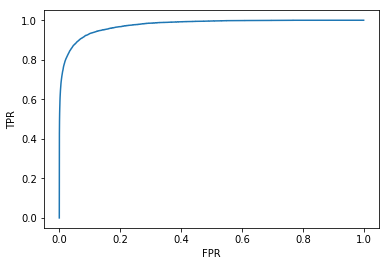

In [225]:
calcEER(scores, res)

In [9]:
z, res = run_test(zscore_col, 0.01, enroll_spk_raw, test_spk)
#sendScores(z, res, 'z')

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


In [231]:
c, res = run_test(cos_similarity, 0.5, enroll_spk, test_spk)

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  5min  2.4s
[########################################] | 100% Completed |  5min  2.5s
[########################################] | 100% Completed |  5min  2.5s
[########################################] | 100% Completed |  5min  2.5s
[########################################] | 100% Completed |  5min  2.6s
[########################################] | 100% Completed |  5min  2.7s
[########################################] | 100% Completed |  5min  2.7s
[#####

Threshold:  0.9147632933420125
EER:  0.07963749733077087


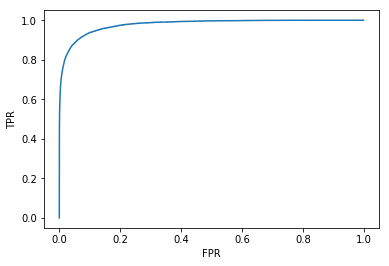

In [229]:
calcEER(c, res)

In [220]:
t = c-0.01*z

In [226]:
calcEER(t, res)

ValueError: Found input variables with inconsistent numbers of samples: [5862654, 117248]

In [207]:
def minFunc(x):
    fpr, tpr, thresholds = roc_curve(res, c-x*z)
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    return fpr[minPt]

In [212]:
minFunc(0)

0.07061577364680154

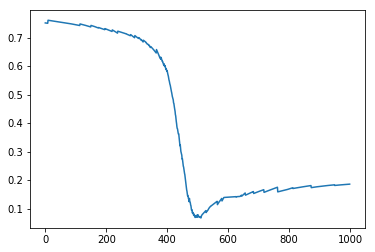

In [218]:
m = []
for p in np.arange(-0.5,0.5,0.001):
    m.append(minFunc(p))
plt.plot(m)

(array([ 1.,  1.,  8., 20., 27., 41., 29., 31., 19., 15.]),
 array([0.87803678, 0.88958707, 0.90113735, 0.91268764, 0.92423792,
        0.9357882 , 0.94733849, 0.95888877, 0.97043905, 0.98198934,
        0.99353962]),
 <a list of 10 Patch objects>)

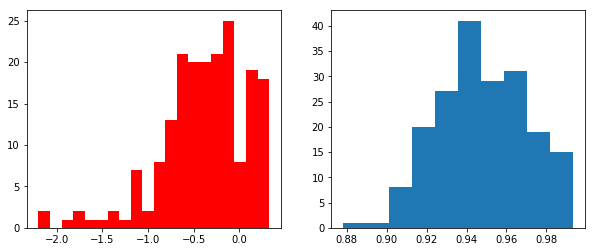

In [195]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(t[res==1], color='red', bins=20)

plt.subplot(122)
plt.hist(c[res==1], bins='auto')

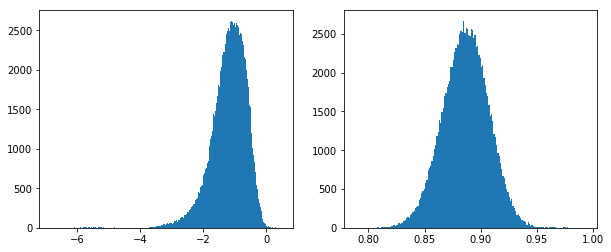

In [196]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(t, bins='auto');

plt.subplot(122)
plt.hist(c, bins='auto');


# median of median z-score on frame-level data

In [9]:
def ark_to_hdf5_raw(filename, num_utts = 100 ):
    """Makes each utterance a dataframe of frame-level d-vectors. It is required to run ark_to_hdf5 first to get the index"""
    def genMultiIndex(utt_names, utt_lengths):
        names = []
        for i, j in enumerate(utt_lengths):
            names += [utt_names[i]]*j
        cols = []
        for i, j in enumerate(utt_lengths):
            cols += [k for k in range(j)]
        return pd.MultiIndex.from_arrays([names, cols], names = ('utt','row'))
    
    HDFS_Name = filename+"_raw.h5"
    store = pd.HDFStore(HDFS_Name)
    utt_names = []
    utt_lengths = [] #this and utt_names should be same length
    last_wd_len = 0
    df_count = 0
    
    with open(FILE_DIR+filename, 'r') as f:
        working_data = []
        utt_id_past = ""
        for line in f:
            if(line[:2].isalpha()):
                utt_id = line[:line.index("[")-2]
                if not utt_id_past:
                    utt_id_past = utt_id
                
                if working_data:
                    last_utt_len = len(working_data) - last_wd_len
                    last_wd_len = len(working_data)
                    utt_lengths.append(last_utt_len)
                    utt_names.append(utt_id_past)
                    
                    if (len(utt_names)>num_utts):
                        data = np.array(working_data, dtype='float64')
                        index = genMultiIndex(utt_names, utt_lengths)
                        pd.DataFrame(index=index, data = data).to_hdf(HDFS_Name, filename[:-4]+"_raw"+str(int(df_count/num_utts)) ,format="table")
                        df_list = np.array([]) 
                        # ONLY WHEN LAST BATCH HAS BEEN WRITTEN TO DISK
                        working_data, utt_lengths, utt_names = [],[],[]
                        last_wd_len = 0        
                    df_count+=1
                    
                if df_count%num_utts==0: 
                    print("Utts processed: ", df_count)      
                utt_id_past = utt_id
                
            else:
                # Add line as another row to the working matrix of df_utterance
                if "]" in line[-3:]: line = line[:-2]
                working_data.append(line.strip().split())
                
        if working_data: #Do same thing with tailing data
            last_utt_len = len(working_data) - last_wd_len
            utt_lengths.append(last_utt_len)
            utt_names.append(utt_id_past)
            data = np.array(working_data, dtype='float64')
            index = genMultiIndex(utt_names, utt_lengths)
            pd.DataFrame(index=index, data = data).to_hdf(HDFS_Name,filename[:-4]+"_raw"+str(int(df_count/num_utts)+1) ,format="table")
            print("Utts processed: ", df_count+1)  
            
            
    return store

In [29]:
pairs.head()

,enroll,test_id,result
0,4780420411,fc_4779547143_0,0
1,4780420411,fc_4779547143_1,0
2,4780420411,fc_4779547143_2,0
3,4780420411,fc_4779547143_3,0
4,4780420411,fc_4779547143_4,0


In [62]:
# takes spkr from raw, test from spk, and returns a single value
def zscore_col(spkr, test):
    std = np.std(spkr, axis=0)
    scores = np.absolute(np.divide((test-spkr.mean(axis=0)), np.where(std!=0, std, 0.0000001)) )
    res = np.median(scores)
    return res

def zscore_col_delayed(spkr, test):
    std = delayed(np.std)(spkr, axis=0)
    scores = delayed(np.absolute)(delayed(np.divide)((delayed(test) - delayed(spkr).mean(axis=0)), delayed(np.where)(std!=0, std, 0.0000001)) )
    res = delayed(np.median)(scores)
    return res
# spkr_utts is a list of utterances associated to one speaker
# returns a float
def zscore_col_framelvl(spkr_utts, test):
    z_res = []
    for u in spkr_utts:
        u_vecs = delayed(enroll_ark).loc[u].values
        z = zscore_col_delayed(u_vecs, test)
        z_res.append(z)
    return delayed(np.median)(z_res)

In [145]:
z, res = run_test(zscore_col, 0.0001, enroll_spk_raw, test_spk)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


In [128]:
z_frame, res = run_test(zscore_col_framelvl, 0.001, enroll_utts, test_spk)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  1min  7.0s
[########################################] | 100% Completed |  1min  7.0s
[########################################] | 100% Completed |  1min  7.0s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


In [131]:
z_frame = dd.compute(*z_frame)

[########################################] | 100% Completed |  7min 11.0s
[########################################] | 100% Completed |  7min 11.1s


In [132]:
np.array(z_frame)[res==1]

array([1.50032324, 1.49263836, 1.58997193, 1.76007257, 1.5448861 ,
       1.57604872, 1.53370577, 1.38370009, 1.57249453, 1.48792185,
       1.60286338, 2.17567701, 1.61840331, 1.84748426, 2.00889771,
       1.72971181, 1.80719291, 1.61115703, 1.59304991, 1.7202844 ,
       2.07927303])

Threshold:  1.5930499099755848
EER:  0.4438370205859742


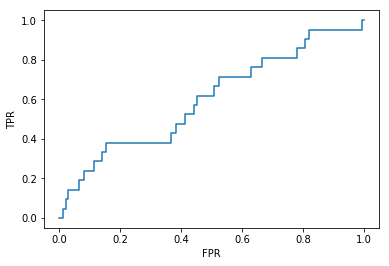

In [133]:
calcEER(z_frame, res)

(array([5.6317e+04, 3.6006e+04, 1.5058e+04, 6.1840e+03, 2.2430e+03,
        8.0600e+02, 4.4400e+02, 1.2900e+02, 4.6000e+01, 1.5000e+01]),
 array([  3.99348572,  42.85339527,  81.71330483, 120.57321438,
        159.43312394, 198.2930335 , 237.15294305, 276.01285261,
        314.87276216, 353.73267172, 392.59258127]),
 <a list of 10 Patch objects>)

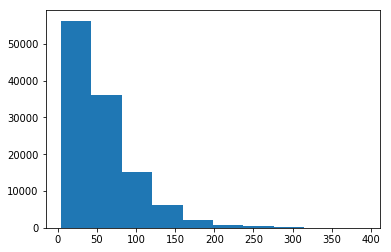

In [60]:
plt.hist(z_frame)

(array([83., 50., 32., 14.,  9.,  1.,  2.,  0.,  0.,  1.]),
 array([ 13.98935999,  40.75914942,  67.52893884,  94.29872827,
        121.06851769, 147.83830712, 174.60809654, 201.37788596,
        228.14767539, 254.91746481, 281.68725424]),
 <a list of 10 Patch objects>)

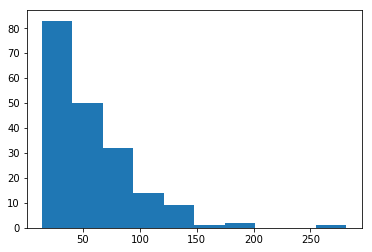

In [61]:
plt.hist(z_frame[res==1])

# KL divergence frame-level

In [ ]:
# Returns a value representative of KL div of 5 speaker utts x 3 test utts
# spkr_utts is a list of utterances associated to one speaker
# returns a float
def kl_framelvl(spkr_utts, test_utts):
    s
    for u in spkr_utts:
        u_vecs = pd.read_hdf('enroll.ark_raw.h5', u)
        z = zscore_col(spkr, test)
        z_avgs.append(z)
    return np.min(z_avgs)

# Minimum KS score on sliding frame-level window? 
This ended up being rather useless because this produces a yes/no result, not exactly a score

In [7]:
from scipy.stats import ks_2samp

In [11]:
spkr

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
utt,,,,,,,,,,,,,,,,,,,,,
utt1,0.016057,0.063447,0.024169,0.020488,0.067268,0.111295,0.075458,0.002725,0.047470,0.044406,...,0.082196,0.031757,0.026153,0.028168,0.026362,0.048117,0.040820,0.025251,0.012643,0.081232
utt2,0.004132,0.042350,0.026292,0.021213,0.055774,0.099405,0.056854,0.000000,0.059910,0.034133,...,0.089012,0.023073,0.018801,0.033256,0.028867,0.053247,0.054419,0.009181,0.002636,0.048796
utt3,0.003735,0.060417,0.041474,0.007404,0.067067,0.119366,0.052364,0.000000,0.056909,0.056164,...,0.094812,0.061538,0.017183,0.027635,0.032651,0.042445,0.030427,0.012174,0.007087,0.087498
utt4,0.023073,0.047888,0.017589,0.011351,0.062918,0.116655,0.081408,0.000000,0.031385,0.042443,...,0.061069,0.027534,0.018113,0.026473,0.038839,0.047355,0.027251,0.014266,0.017972,0.052178
utt5,0.021832,0.054759,0.016714,0.022291,0.057607,0.116154,0.078686,0.000058,0.028728,0.043503,...,0.055377,0.017151,0.030925,0.022040,0.046488,0.039413,0.024504,0.018720,0.016129,0.077600


In [14]:
spkr.values

array([[0.01605674, 0.06344705, 0.02416925, ..., 0.02525054, 0.0126431 ,
        0.08123245],
       [0.00413164, 0.04235032, 0.02629241, ..., 0.0091815 , 0.00263551,
        0.04879643],
       [0.00373536, 0.06041709, 0.04147403, ..., 0.01217359, 0.00708702,
        0.08749822],
       [0.02307299, 0.04788809, 0.01758919, ..., 0.01426579, 0.01797234,
        0.05217803],
       [0.02183153, 0.05475891, 0.01671441, ..., 0.01872049, 0.01612858,
        0.07759994]])

In [20]:
spkr, test = load_sample(enroll_spk_raw, test_spk_raw)

In [62]:
spkr,test = load_sample(enroll_spk_raw, test_spk_raw, tid='fc_4780420411_0')

In [42]:
spkr.values.shape

(5, 400)

In [63]:
x = []
for i in range(VEC_DIM):
    x.append(ks_2samp(spkr.values[:,i], test.values[:,i])[1])

In [64]:
max(x)

0.9947617791845264

In [60]:
pairs[(pairs['enroll']==4780420411) & (pairs['result']==1)]

,enroll,test_id,result
5988,4780420411,fc_4780420411_0,1
5989,4780420411,fc_4780420411_1,1
5990,4780420411,fc_4780420411_2,1
5991,4780420411,fc_4780420411_3,1
5992,4780420411,fc_4780420411_4,1
5993,4780420411,fc_4780420411_5,1
5994,4780420411,fc_4780420411_6,1
5995,4780420411,fc_4780420411_7,1
4502097,4780420411,nc_4780420411_0,1
4502098,4780420411,nc_4780420411_1,1


In [57]:
pairs.head()

,enroll,test_id,result
0,4780420411,fc_4779547143_0,0
1,4780420411,fc_4779547143_1,0
2,4780420411,fc_4779547143_2,0
3,4780420411,fc_4779547143_3,0
4,4780420411,fc_4779547143_4,0


<BarContainer object of 10 artists>

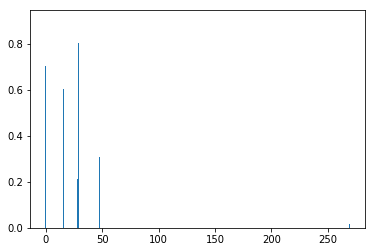

In [55]:
h, b = np.histogram(x)
plt.bar(h,b[:-1])

In [39]:
np.apply_along_axis(ks_2samp, 0, arr=spkr.values, data2=test.values)

ValueError: all the input arrays must have same number of dimensions

In [36]:
ks_2samp(spkr.values[:,4], test.values[:,4])

Ks_2sampResult(statistic=0.4, pvalue=0.8253945153851224)